# 
- Are neighboring cartridges more similar to each other in connection counts than non-neighboring cartridges?
- Does a circuit's connection counts vary stochastically across the eye, or are certain connection counts dependent on the retinotopic position of the lamina cartridge?
- By comparing the connection counts of all neighboring trios to randomly sampled non-neighboring trios, we can show the extent to which our methodology succeeds at capturing retinotopic variability that may exist in different regions of the eye. 

In [109]:
import os.path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import comb
from scipy.stats import mannwhitneyu, kstest, zscore
from typing import Tuple
from itertools import combinations
import statsmodels.api as sm

import sys
sys.path.extend(['.', '..'])
from cx_analysis.utils import index_by_om
from vis.hex_lattice import om_to_hex

import matplotlib as mpl
plt.rcdefaults()
plt.style.use('vis/lamina.mplstyle')

In [34]:
tp = '210615'
data_path = f'~/Data/{tp}_lamina/{tp}_cxdf.pickle'
cxdf = pd.read_pickle(data_path)
df_all = index_by_om(cxdf)
# Filter out connection types with mean < 1? 
criteria = [(df_all[ct].mean() >= 0.0) for ct in df_all.columns]
cx_df = df_all.loc[:, criteria]
om_list = cx_df.index

save_figs = False
# if save_figs:
#     fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/FNAME.svg')
#     fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/FNAME.png')

In [73]:
def id_to_ascii(om: str) -> Tuple:
    
    return ord(om[0]), int(om[1])

def coord_to_id(coord: Tuple) -> str:
    
    return ''.join((chr(coord[0]), str(coord[1])))

def ommatidial_distance(o1: str, o2: str) -> float:
    c1 = np.array(om_to_hex(o1, scale_factor=1.0))
    c2 = np.array(om_to_hex(o2, scale_factor=1.0))
    
    return np.linalg.norm(c1-c2)

def x_dist(o1: str, o2: str) -> float:
    c1 = np.array(om_to_hex(o1, scale_factor=1.0))
    c2 = np.array(om_to_hex(o2, scale_factor=1.0))
    
    return abs(c1[0] - c2[0])

def y_dist(o1: str, o2: str) -> float:
    c1 = np.array(om_to_hex(o1, scale_factor=1.0))
    c2 = np.array(om_to_hex(o2, scale_factor=1.0))
    
    return abs(c1[1] - c2[1])
            
def cx_fano(df: pd.DataFrame) -> float:
    cx_var = df.var(ddof=0)
    cx_mn = df.mean()
    
    return (cx_var/cx_mn).mean()

def cx_fano_fill(df: pd.DataFrame) -> float:
    cx_var = df.var(ddof=0)
    cx_mn = df.mean()
    
    return (cx_var/cx_mn).fillna(0.0).mean()

In [86]:
pairs = [(o1, o2) for o1, o2 in combinations(om_list, 2)]

pair_om_dist = pd.Series(index=pairs, name='om_dist', dtype=float)
pair_x_dist = pd.Series(index=pairs, name='x_dist', dtype=float)
pair_y_dist = pd.Series(index=pairs, name='y_dist', dtype=float)

pair_cx_fano = pd.Series(index=pairs, name='cx_fano', dtype=float)
pair_cx_dist = pd.Series(index=pairs, name='cx_dist', dtype=float)

for o1, o2 in pairs:
    
    pair_om_dist[(o1, o2)] = ommatidial_distance(o1, o2)
    pair_x_dist[(o1, o2)] = x_dist(o1, o2)
    pair_y_dist[(o1, o2)] = y_dist(o1, o2)
    
    pair_cx_fano[(o1, o2)] = cx_fano_fill(cx_df.loc[(o1, o2), :])
    pair_cx_dist[(o1, o2)] = np.linalg.norm(cx_df.loc[o1] - cx_df.loc[o2])
    
df = pd.DataFrame([pair_om_dist, pair_x_dist, pair_y_dist, pair_cx_fano, pair_cx_dist]).T
display(df)

,om_dist,x_dist,y_dist,cx_fano,cx_dist
"(A0, A1)",1.0,0.0,1.0,0.344694,47.476310
"(A0, A2)",2.0,0.0,2.0,0.510906,53.702886
"(A0, A3)",3.0,0.0,3.0,0.351841,57.105166
"(A0, A4)",4.0,0.0,4.0,0.327273,44.721360
"(A0, A5)",5.0,0.0,5.0,0.344836,45.122057
...,...,...,...,...,...
"(E4, E6)",2.0,0.0,2.0,0.298910,34.741906
"(E4, E7)",3.0,0.0,3.0,0.324683,39.484174
"(E5, E6)",1.0,0.0,1.0,0.349273,42.953463
"(E5, E7)",2.0,0.0,2.0,0.351814,44.034078


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                cx_fano   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     94.26
Date:                Thu, 01 Jul 2021   Prob (F-statistic):           3.61e-20
Time:                        13:21:01   Log-Likelihood:                 244.11
No. Observations:                 406   AIC:                            -484.2
Df Residuals:                     404   BIC:                            -476.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3269      0.016     20.852      0.000       0.296       0.358
om_dist        0.0503      0.005      9.709      0.000       0.040       0.060
==============================================================================
Omnibus:                       25.062   Durbin-Watson:                   1.362
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.030
Skew:                           0.603   Prob(JB):                     8.19e-07
Kurtosis:                       3.448   Cond. No.                         7.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

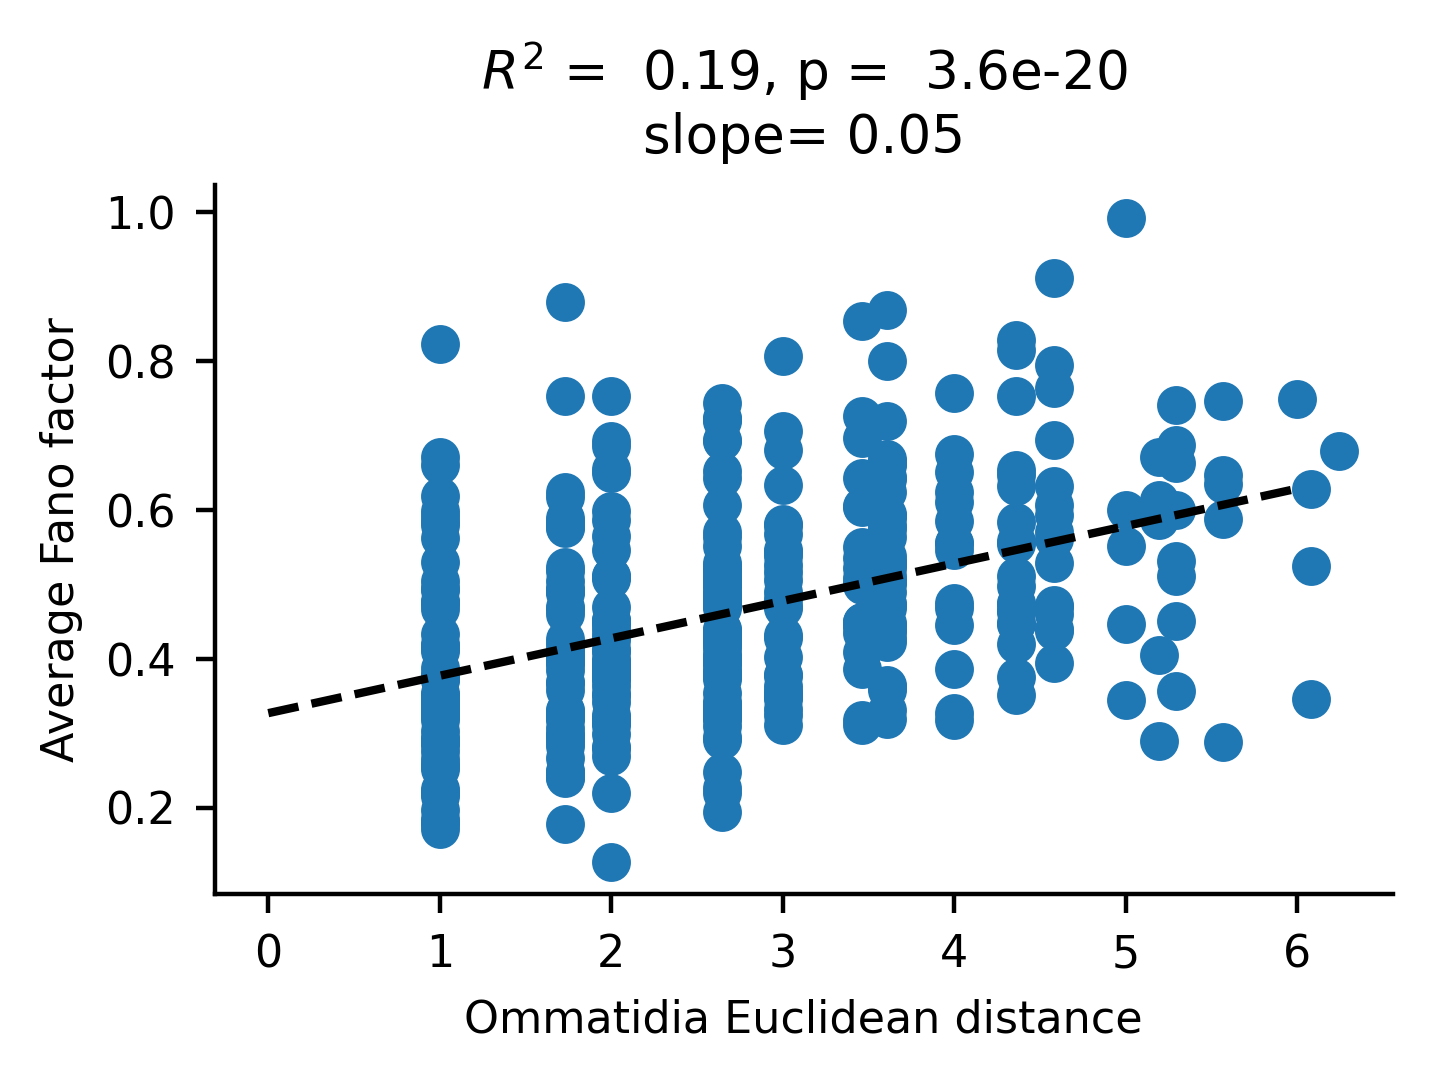

In [96]:
fig, ax = plt.subplots(1)

_x = df['om_dist']
X = sm.add_constant(_x)
Y = df['cx_fano']

model = sm.OLS(Y, X)
results = model.fit()
params = results.params

ax.scatter(x=_x, y=Y, marker='o')
#ax[1].annotate(jp_right.index, (_x, Y))
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p = {results.f_pvalue: .1e}\n' +
                f'slope={params[1]: .2f}')
ax.set_xlabel("Ommatidia Euclidean distance")
ax.set_ylabel("Average Fano factor")

xx = np.arange(0, max(_x))
ax.plot(xx, params[1] * xx + params[0], c='k', ls='--')

display(results.summary())

In [ ]:
# SCRAMBLED



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                cx_dist   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     62.73
Date:                Thu, 01 Jul 2021   Prob (F-statistic):           2.31e-14
Time:                        13:20:38   Log-Likelihood:                -1540.2
No. Observations:                 406   AIC:                             3084.
Df Residuals:                     404   BIC:                             3092.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.2909      1.270     35.652      0.000      42.794      47.788
om_dist        3.3223      0.419      7.921      0.000       2.498       4.147
==============================================================================
Omnibus:                       17.049   Durbin-Watson:                   1.329
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.021
Skew:                           0.502   Prob(JB):                     0.000122
Kurtosis:                       3.235   Cond. No.                         7.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

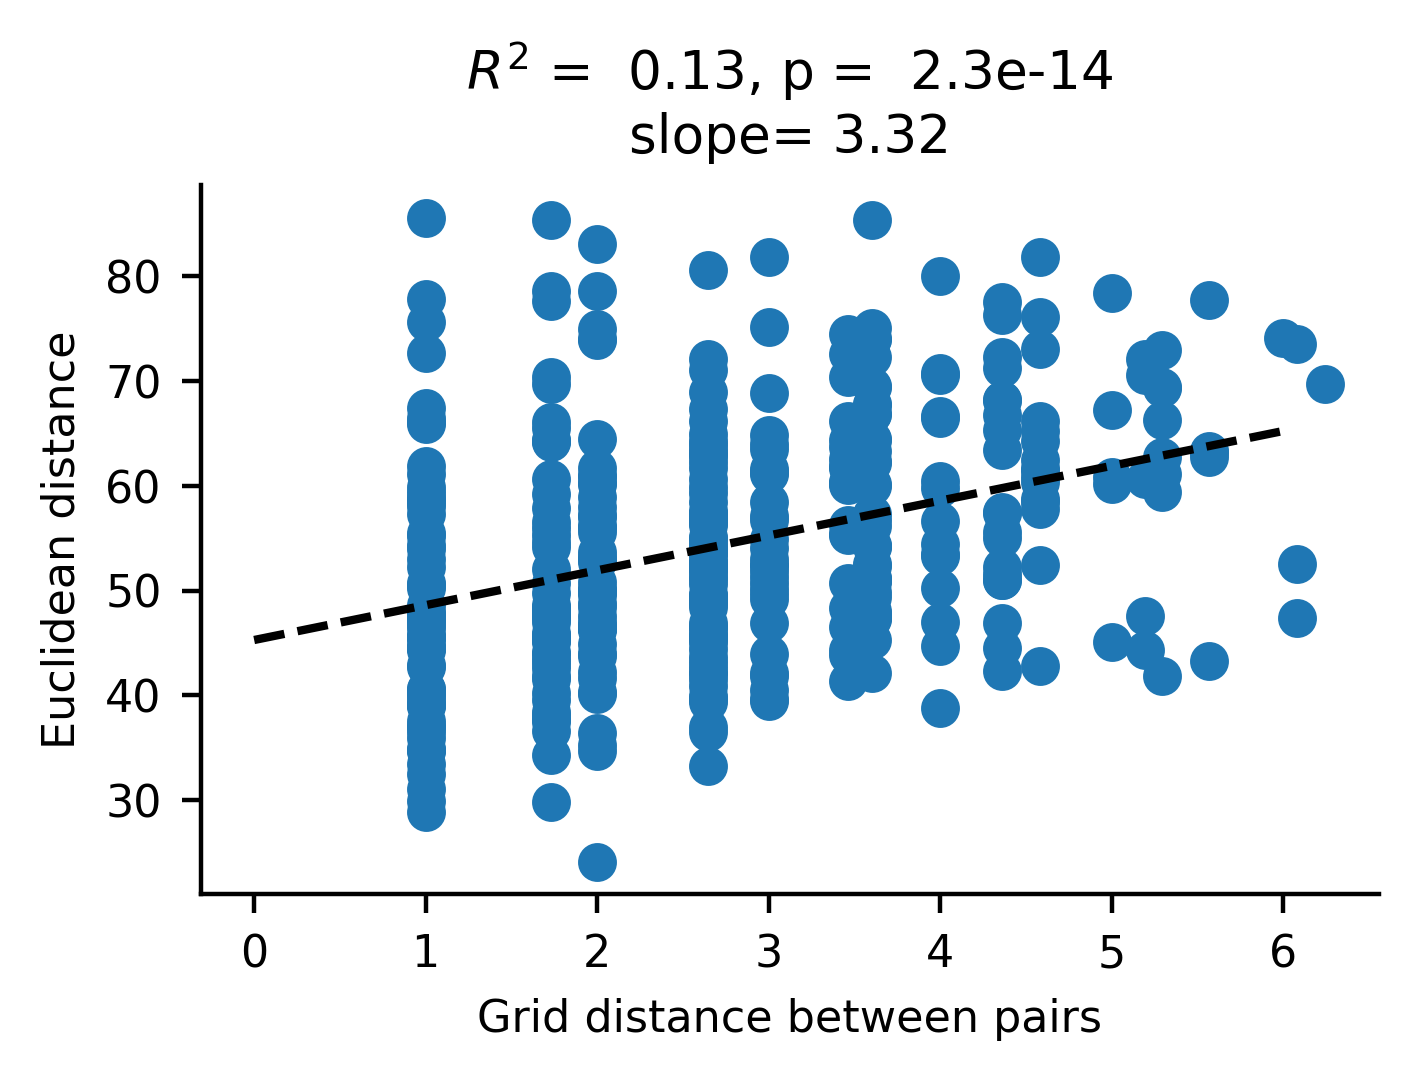

In [95]:
fig, ax = plt.subplots(1)

_x = df['om_dist']
X = sm.add_constant(_x)
Y = df['cx_dist']

model = sm.OLS(Y, X)
results = model.fit()
params = results.params

ax.scatter(x=_x, y=Y, marker='o')
#ax[1].annotate(jp_right.index, (_x, Y))
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p = {results.f_pvalue: .1e}\n' +
                f'slope={params[1]: .2f}')
ax.set_xlabel("Grid distance between pairs")
ax.set_ylabel("Euclidean distance")

xx = np.arange(0, max(_x))
ax.plot(xx, params[1] * xx + params[0], c='k', ls='--')

display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                cx_fano   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     10.10
Date:                Thu, 01 Jul 2021   Prob (F-statistic):            0.00159
Time:                        13:20:04   Log-Likelihood:                 206.55
No. Observations:                 406   AIC:                            -409.1
Df Residuals:                     404   BIC:                            -401.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4330      0.012     34.936      0.000       0.409       0.457
x_dist         0.0236      0.007      3.179      0.002       0.009       0.038
==============================================================================
Omnibus:                       23.422   Durbin-Watson:                   1.243
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.855
Skew:                           0.586   Prob(JB):                     2.43e-06
Kurtosis:                       3.394   Cond. No.                         3.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

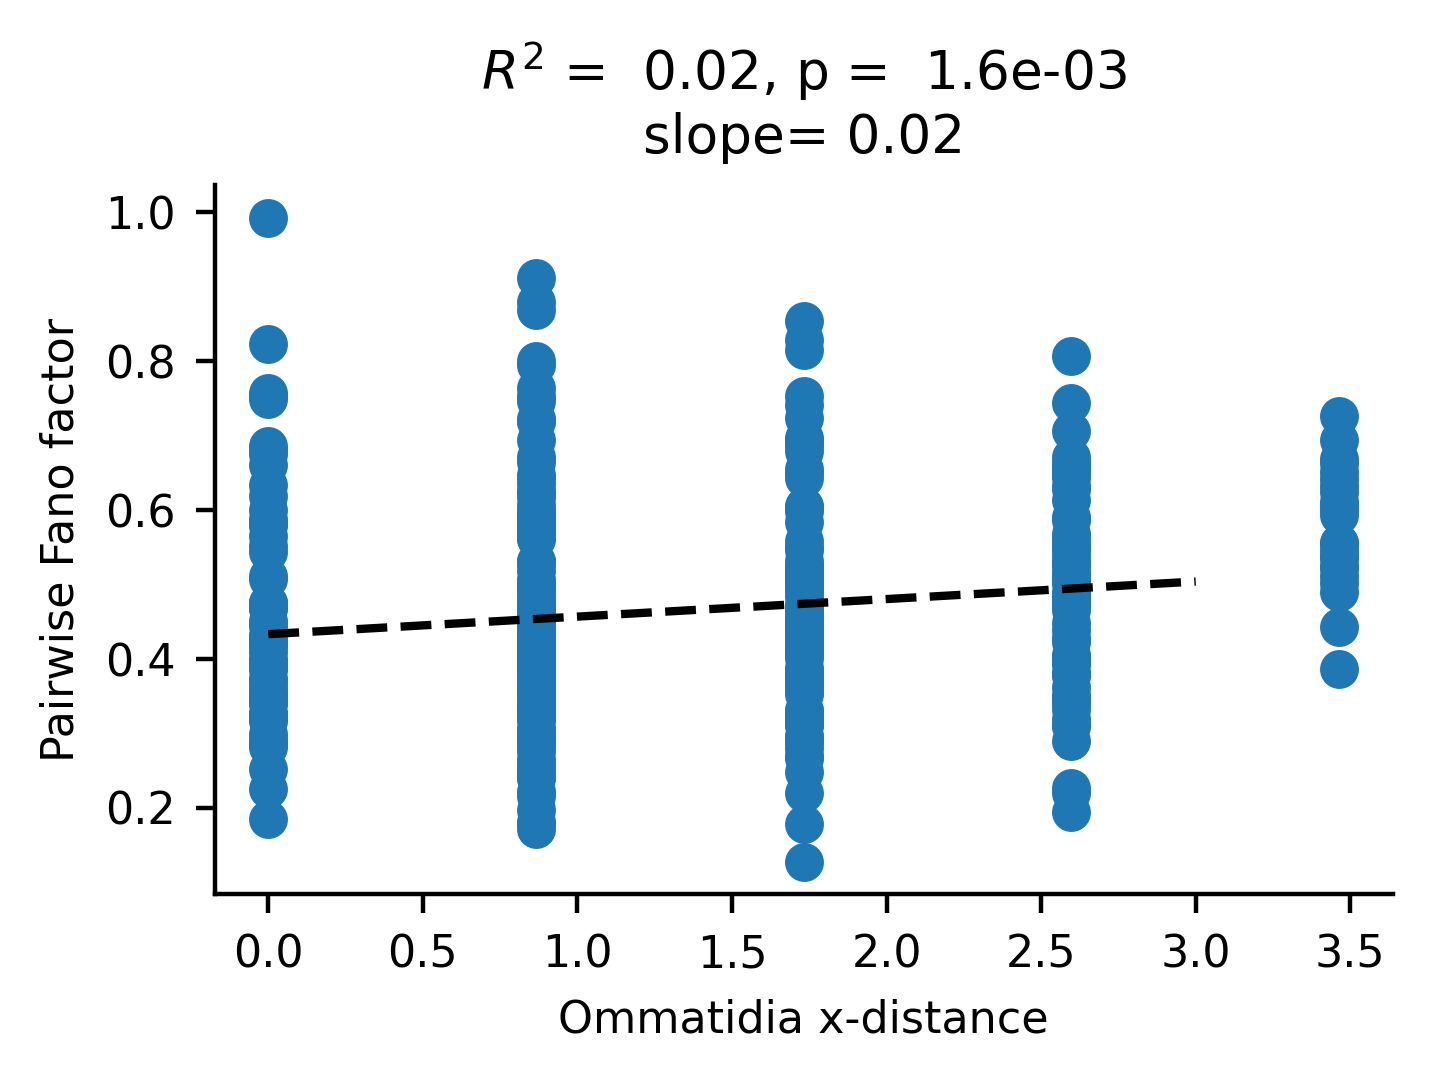

In [93]:
fig, ax = plt.subplots(1)

_x = df['x_dist']
X = sm.add_constant(_x)
Y = df['cx_fano']

model = sm.OLS(Y, X)
results = model.fit()
params = results.params

ax.scatter(x=_x, y=Y, marker='o')
#ax[1].annotate(jp_right.index, (_x, Y))
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p = {results.f_pvalue: .1e}\n' +
                f'slope={params[1]: .2f}')
ax.set_xlabel("Ommatidia x-distance")
ax.set_ylabel("Pairwise Fano factor")

xx = np.arange(0, max(_x))
ax.plot(xx, params[1] * xx + params[0], c='k', ls='--')

display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                cx_fano   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     70.49
Date:                Thu, 01 Jul 2021   Prob (F-statistic):           7.89e-16
Time:                        13:20:14   Log-Likelihood:                 234.18
No. Observations:                 406   AIC:                            -464.4
Df Residuals:                     404   BIC:                            -456.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3815      0.012     31.720      0.000       0.358       0.405
y_dist         0.0400      0.005      8.396      0.000       0.031       0.049
==============================================================================
Omnibus:                       17.355   Durbin-Watson:                   1.352
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.735
Skew:                           0.526   Prob(JB):                     8.55e-05
Kurtosis:                       3.024   Cond. No.                         5.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

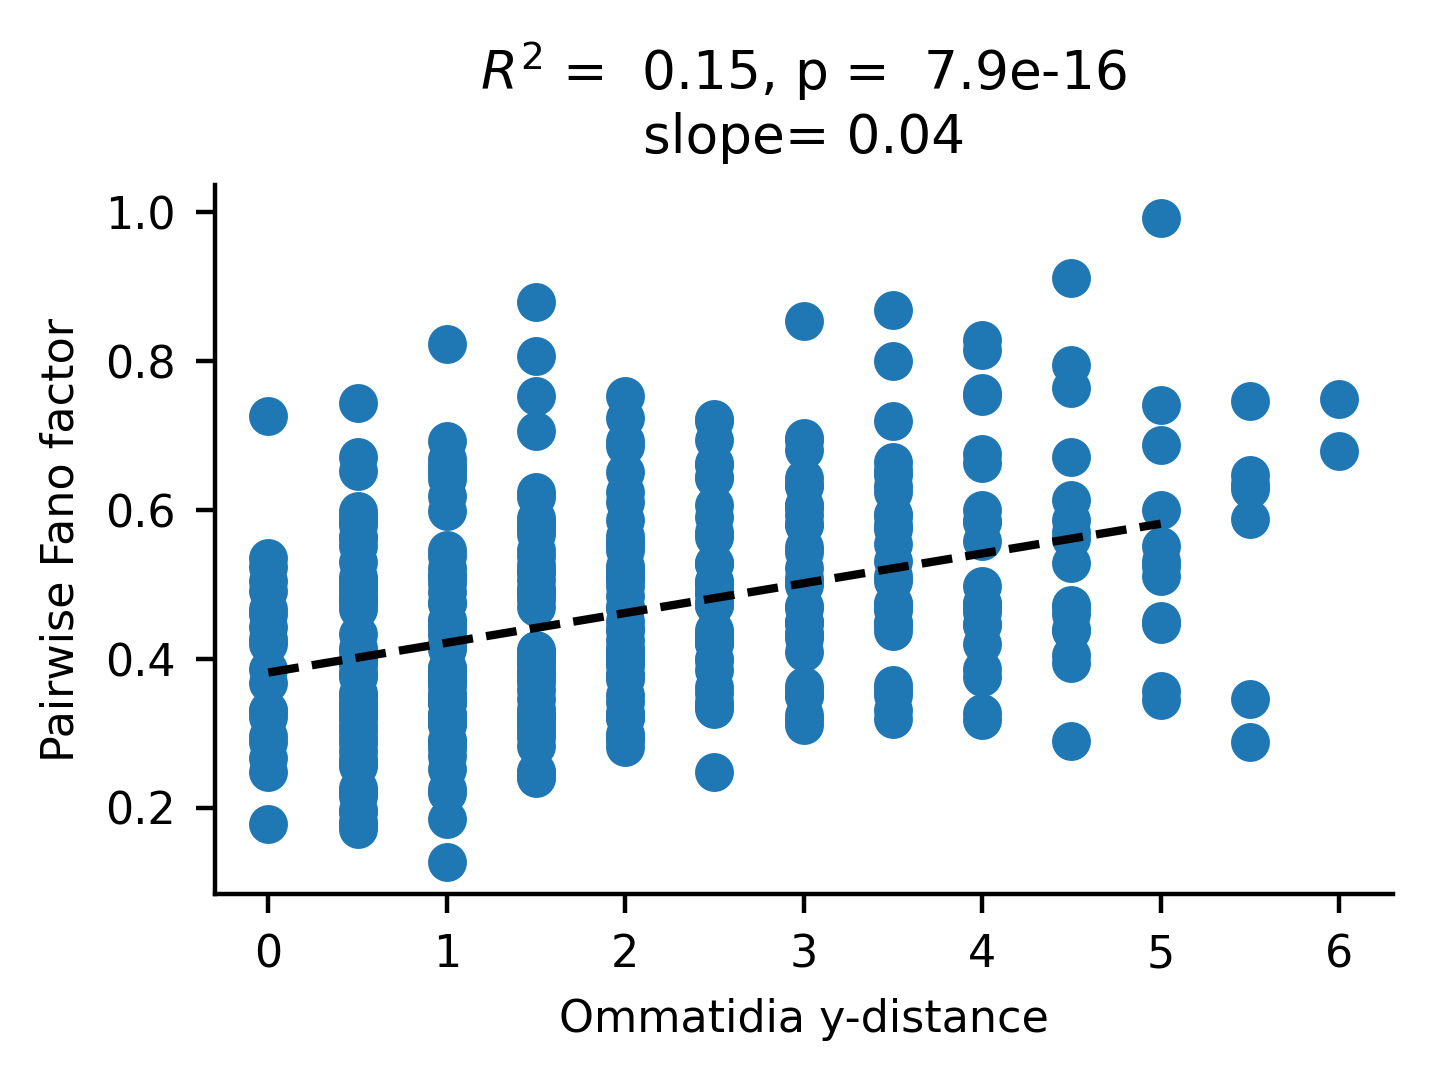

In [94]:
fig, ax = plt.subplots(1)

_x = df['y_dist']
X = sm.add_constant(_x)
Y = df['cx_fano']

model = sm.OLS(Y, X)
results = model.fit()
params = results.params

ax.scatter(x=_x, y=Y, marker='o')
#ax[1].annotate(jp_right.index, (_x, Y))
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p = {results.f_pvalue: .1e}\n' +
                f'slope={params[1]: .2f}')
ax.set_xlabel("Ommatidia y-distance")
ax.set_ylabel("Pairwise Fano factor")

xx = np.arange(0, max(_x))
ax.plot(xx, params[1] * xx + params[0], c='k', ls='--')

display(results.summary())

### Multivariate OLS 
To what extent can the retinal distance be predicted by the difference of all connection counts?



In [133]:
_x = pd.DataFrame([(cx_df.loc[o1] - cx_df.loc[o2]).abs() for o1, o2 in pairs], index=pairs)
#display(_x)
X = sm.add_constant(_x)
Y = df['om_dist']

model = sm.GLM(Y, X, family=sm.families.Poisson())
results = model.fit()
params = results.params

display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                om_dist   No. Observations:                  406
Model:                            GLM   Df Residuals:                      320
Model Family:                 Poisson   Df Model:                           85
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -603.31
Date:                Fri, 02 Jul 2021   Deviance:                       67.564
Time:                        13:16:27   Pearson chi2:                     66.1
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0343      0.300      0.114      0.909      -0.553       0.622
R2R5->LMC_2       -0.0011      0.005     -0.206      0.837      -0.011       0.009
R1R4->LMC_2       -0.0027      0.006     -0.450      0.652      -0.015       0.009
R3R6->LMC_2       -0.0013      0.006     -0.199      0.843      -0.014       0.011
R2R5->LMC_3       -0.0056      0.007     -0.822      0.411      -0.019       0.008
R1R4->LMC_1        0.0059      0.008      0.766      0.444      -0.009       0.021
R2R5->LMC_1       -0.0045      0.009     -0.510      0.610      -0.022       0.013
R2R5->centri       0.0022      0.008      0.293      0.770      -0.013       0.017
R3R6->LMC_1    -4.841e-05      0.007     -0.007      0.995      -0.014       0.014
centri->R7p       -0.0018      0.009     -0.192      0.848      -0.020       0.016
centri->R2R5       0.0005      0.010      0.048      0.962      -0.019       0.020
LMC_2->LMC_1      -0.0046      0.010     -0.444      0.657      -0.025       0.016
centri->LMC_2      0.0038      0.008      0.475      0.634      -0.012       0.019
R3R6->LMC_3        0.0077      0.008      0.918      0.359      -0.009       0.024
R1R4->LMC_3       -0.0022      0.009     -0.236      0.814      -0.020       0.016
centri->R8         0.0125      0.012      1.021      0.307      -0.011       0.036
centri->LMC_3     -0.0022      0.008     -0.266      0.790      -0.018       0.014
LMC_2->LMC_4       0.0024      0.008      0.319      0.750      -0.013       0.017
R2R5->LMC_4        0.0111      0.007      1.600      0.109      -0.002       0.025
LMC_2->LMC_3       0.0217      0.010      2.261      0.024       0.003       0.041
R1R4->centri      -0.0121      0.012     -1.016      0.310      -0.036       0.011
R2R5->R7p          0.0171      0.011      1.598      0.110      -0.004       0.038
R3R6->centri       0.0008      0.009      0.093      0.926      -0.016       0.018
centri->LMC_1      0.0131      0.017      0.748      0.454      -0.021       0.047
centri->R7         0.0455      0.011      4.040      0.000       0.023       0.068
R1R4->R2R5         0.0032      0.021      0.153      0.879      -0.038       0.044
LMC_2->LMC_2      -0.0070      0.010     -0.677      0.498      -0.027       0.013
R3R6->LMC_4       -0.0019      0.015     -0.128      0.898      -0.031       0.027
R3R6->R2R5        -0.0029      0.025     -0.116      0.908      -0.053       0.047
R1R4->LMC_4       -0.0019      0.015     -0.131      0.896      -0.031       0.027
LMC_2->R7p         0.0264      0.018      1.482      0.138      -0.009       0.061
LMC_2->centri     -0.0120      0.014     -0.878      0.380      -0.039       0.015
LMC_N->LMC_1      -0.0027      0.015     -0.183      0.855      -0.031       0.026
centri->LMC_4      0.0056      0.019      0.292      0.770      -0.032       0.043
LMC_N->LMC_3

In [139]:
_x = pd.DataFrame([(cx_df.loc[o1] - cx_df.loc[o2]).abs() for o1, o2 in pairs], index=pairs)
display(_x)
X = sm.add_constant(_x)
Y = df['om_dist']

model = sm.OLS(Y, X)
results = model.fit()
params = results.params

display(results.summary())

cx_type,R2R5->LMC_2,R1R4->LMC_2,R3R6->LMC_2,R2R5->LMC_3,R1R4->LMC_1,R2R5->LMC_1,R2R5->centri,R3R6->LMC_1,centri->R7p,centri->R2R5,...,LMC_4->R1R4,LMC_4->LMC_4,LMC_3->centri,LMC_3->R8,LMC_3->R7p,LMC_3->R7,LMC_3->R3R6,R8->R1R4,LMC_3->R1R4,R7->R7
"(A0, A1)",12.0,21.0,12.0,7.0,4.0,1.0,7.0,6.0,7.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(A0, A2)",5.0,6.0,16.0,4.0,7.0,11.0,26.0,16.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(A0, A3)",26.0,8.0,17.0,3.0,5.0,2.0,15.0,8.0,17.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(A0, A4)",7.0,8.0,3.0,7.0,2.0,3.0,10.0,13.0,12.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(A0, A5)",11.0,2.0,0.0,16.0,3.0,1.0,7.0,19.0,2.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(E4, E6)",11.0,1.0,10.0,6.0,1.0,7.0,8.0,5.0,7.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(E4, E7)",6.0,7.0,3.0,3.0,7.0,3.0,3.0,1.0,9.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(E5, E6)",7.0,5.0,1.0,21.0,6.0,6.0,12.0,4.0,10.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(E5, E7)",2.0,13.0,8.0,18.0,2.0,4.0,1.0,0.0,12.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                om_dist   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     10.87
Date:                Fri, 02 Jul 2021   Prob (F-statistic):           5.00e-57
Time:                        13:27:37   Log-Likelihood:                -399.10
No. Observations:                 406   AIC:                             970.2
Df Residuals:                     320   BIC:                             1315.
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3723      0.346      1.078      0.282      -0.307       1.052
R2R5->LMC_2    -6.069e-05      0.006     -0.010      0.992      -0.012       0.012
R1R4->LMC_2       -0.0100      0.007     -1.409      0.160      -0.024       0.004
R3R6->LMC_2       -0.0054      0.008     -0.691      0.490      -0.021       0.010
R2R5->LMC_3       -0.0139      0.008     -1.752      0.081      -0.030       0.002
R1R4->LMC_1        0.0182      0.009      2.042      0.042       0.001       0.036
R2R5->LMC_1       -0.0074      0.010     -0.728      0.467      -0.028       0.013
R2R5->centri       0.0045      0.009      0.505      0.614      -0.013       0.022
R3R6->LMC_1        0.0023      0.009      0.276      0.783      -0.014       0.019
centri->R7p       -0.0064      0.011     -0.590      0.556      -0.028       0.015
centri->R2R5       0.0049      0.012      0.418      0.676      -0.018       0.028
LMC_2->LMC_1      -0.0106      0.012     -0.857      0.392      -0.035       0.014
centri->LMC_2      0.0111      0.009      1.224      0.222      -0.007       0.029
R3R6->LMC_3        0.0189      0.010      1.902      0.058      -0.001       0.038
R1R4->LMC_3       -0.0056      0.011     -0.523      0.601      -0.027       0.016
centri->R8         0.0327      0.014      2.257      0.025       0.004       0.061
centri->LMC_3     -0.0042      0.010     -0.431      0.667      -0.023       0.015
LMC_2->LMC_4       0.0060      0.009      0.656      0.512      -0.012       0.024
R2R5->LMC_4        0.0300      0.008      3.698      0.000       0.014       0.046
LMC_2->LMC_3       0.0460      0.011      4.187      0.000       0.024       0.068
R1R4->centri      -0.0327      0.014     -2.371      0.018      -0.060      -0.006
R2R5->R7p          0.0529      0.012      4.244      0.000       0.028       0.077
R3R6->centri       0.0006      0.010      0.055      0.956      -0.020       0.021
centri->LMC_1      0.0304      0.021      1.468      0.143      -0.010       0.071
centri->R7         0.1223      0.013      9.375      0.000       0.097       0.148
R1R4->R2R5         0.0108      0.025      0.430      0.668      -0.039       0.060
LMC_2->LMC_2      -0.0134      0.012     -1.073      0.284      -0.038       0.011
R3R6->LMC_4       -0.0094      0.017     -0.543      0.588      -0.043       0.025
R3R6->R2R5         0.0091      0.030      0.306      0.760      -0.049       0.067
R1R4->LMC_4        0.0005      0.017      0.031      0.975      -0.034       0.035
LMC_2->R7p         0.0796      0.021      3.796      0.000       0.038       0.121
LMC_2->centri     -0.0323      0.016     -1.964      0.050      -0.065    5.02e-05
LMC_N->LMC_1      -0.0135      0.016     -0.825      0.410      -0.046       0.019
centri->LMC_4      0.0206      0.022      0.934      0.351      -0.023       0.064
LMC_N->LMC_3

In [121]:
zcx = pd.DataFrame(zscore(cx_df), index=cx_df.index, columns=cx_df.columns).fillna(0)#.dropna(axis=1)
display(zcx)

_x = pd.DataFrame([(zcx.loc[o1] - zcx.loc[o2]).abs() for o1, o2 in pairs], index=pairs)
display(_x)
X = sm.add_constant(_x)
Y = df['om_dist']

model = sm.OLS(Y, X)
results = model.fit()
params = results.params

display(results.summary())

cx_type,R2R5->LMC_2,R1R4->LMC_2,R3R6->LMC_2,R2R5->LMC_3,R1R4->LMC_1,R2R5->LMC_1,R2R5->centri,R3R6->LMC_1,centri->R7p,centri->R2R5,...,LMC_4->R1R4,LMC_4->LMC_4,LMC_3->centri,LMC_3->R8,LMC_3->R7p,LMC_3->R7,LMC_3->R3R6,R8->R1R4,LMC_3->R1R4,R7->R7
om,,,,,,,,,,,,,,,,,,,,,
A0,-0.558964,-0.850602,-1.424877,0.210880,0.233774,0.449776,0.360037,1.461444,-1.447583,-0.715102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1,0.672172,1.701204,0.217034,-0.680965,0.671158,0.608843,-0.336034,0.768552,-0.312991,-1.373449,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2,-0.045991,-0.121515,0.764338,-0.298746,-0.531648,-1.299963,-2.225371,-0.386267,-1.447583,-2.360970,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A3,2.108496,0.121515,0.901164,-0.171340,-0.312956,0.767910,1.851618,0.537588,1.307855,-0.550515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A4,0.159199,0.121515,-1.014399,1.102724,0.015082,-0.027425,-0.634351,-0.039821,0.497432,0.930767,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A5,0.569577,-0.607573,-1.424877,-1.827623,-0.094264,0.608843,1.056108,-0.732713,-1.123414,0.766180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B0,0.466982,-0.850602,1.585294,-0.426152,3.295463,-0.186493,-1.628738,2.616264,-1.285498,-2.031796,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B1,-1.892694,-1.458175,-1.698529,-0.553559,0.452466,0.767910,1.851618,-0.501749,0.821601,0.601593,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B2,0.261793,-0.729087,0.217034,-0.808372,-0.422302,-0.822761,-0.037718,-0.501749,2.118277,0.766180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


cx_type,R2R5->LMC_2,R1R4->LMC_2,R3R6->LMC_2,R2R5->LMC_3,R1R4->LMC_1,R2R5->LMC_1,R2R5->centri,R3R6->LMC_1,centri->R7p,centri->R2R5,...,LMC_4->R1R4,LMC_4->LMC_4,LMC_3->centri,LMC_3->R8,LMC_3->R7p,LMC_3->R7,LMC_3->R3R6,R8->R1R4,LMC_3->R1R4,R7->R7
"(A0, A1)",1.231135,2.551805,1.641911,0.891845,0.437384,0.159067,0.696071,0.692892,1.134592,0.658347,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(A0, A2)",0.512973,0.729087,2.189215,0.509626,0.765422,1.749739,2.585408,1.847711,0.000000,1.645869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(A0, A3)",2.667460,0.972116,2.326041,0.382219,0.546730,0.318134,1.491582,0.923856,2.755437,0.164587,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(A0, A4)",0.718162,0.972116,0.410478,0.891845,0.218692,0.477202,0.994388,1.501265,1.945014,1.645869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(A0, A5)",1.128541,0.243029,0.000000,2.038502,0.328038,0.159067,0.696071,2.194157,0.324169,1.481282,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(E4, E6)",1.128541,0.121515,1.368259,0.764438,0.109346,1.113470,0.795510,0.577410,1.134592,1.152108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(E4, E7)",0.615568,0.850602,0.410478,0.382219,0.765422,0.477202,0.298316,0.115482,1.458761,0.822934,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(E5, E6)",0.718162,0.607573,0.136826,2.675534,0.656076,0.954403,1.193265,0.461928,1.620845,1.152108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(E5, E7)",0.205189,1.579689,1.094608,2.293315,0.218692,0.636269,0.099439,0.000000,1.945014,0.822934,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                om_dist   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     10.87
Date:                Fri, 02 Jul 2021   Prob (F-statistic):           5.00e-57
Time:                        12:48:24   Log-Likelihood:                -399.10
No. Observations:                 406   AIC:                             970.2
Df Residuals:                     320   BIC:                             1315.
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3723      0.346      1.078      0.282      -0.307       1.052
R2R5->LMC_2       -0.0006      0.062     -0.010      0.992      -0.122       0.121
R1R4->LMC_2       -0.0819      0.058     -1.409      0.160      -0.196       0.032
R3R6->LMC_2       -0.0392      0.057     -0.691      0.490      -0.151       0.072
R2R5->LMC_3       -0.1093      0.062     -1.752      0.081      -0.232       0.013
R1R4->LMC_1        0.1663      0.081      2.042      0.042       0.006       0.326
R2R5->LMC_1       -0.0468      0.064     -0.728      0.467      -0.173       0.080
R2R5->centri       0.0452      0.089      0.505      0.614      -0.131       0.221
R3R6->LMC_1        0.0203      0.074      0.276      0.783      -0.125       0.165
centri->R7p       -0.0393      0.067     -0.590      0.556      -0.171       0.092
centri->R2R5       0.0297      0.071      0.418      0.676      -0.110       0.170
LMC_2->LMC_1      -0.0504      0.059     -0.857      0.392      -0.166       0.065
centri->LMC_2      0.0869      0.071      1.224      0.222      -0.053       0.227
R3R6->LMC_3        0.1424      0.075      1.902      0.058      -0.005       0.290
R1R4->LMC_3       -0.0417      0.080     -0.523      0.601      -0.199       0.115
centri->R8         0.1726      0.076      2.257      0.025       0.022       0.323
centri->LMC_3     -0.0259      0.060     -0.431      0.667      -0.144       0.092
LMC_2->LMC_4       0.0555      0.085      0.656      0.512      -0.111       0.222
R2R5->LMC_4        0.2843      0.077      3.698      0.000       0.133       0.436
LMC_2->LMC_3       0.3070      0.073      4.187      0.000       0.163       0.451
R1R4->centri      -0.2274      0.096     -2.371      0.018      -0.416      -0.039
R2R5->R7p          0.2781      0.066      4.244      0.000       0.149       0.407
R3R6->centri       0.0040      0.072      0.055      0.956      -0.138       0.146
centri->LMC_1      0.0892      0.061      1.468      0.143      -0.030       0.209
centri->R7         0.7406      0.079      9.375      0.000       0.585       0.896
R1R4->R2R5         0.0243      0.056      0.430      0.668      -0.087       0.135
LMC_2->LMC_2      -0.0592      0.055     -1.073      0.284      -0.168       0.049
R3R6->LMC_4       -0.0375      0.069     -0.543      0.588      -0.173       0.098
R3R6->R2R5         0.0196      0.064      0.306      0.760      -0.106       0.146
R1R4->LMC_4        0.0021      0.069      0.031      0.975      -0.133       0.137
LMC_2->R7p         0.2961      0.078      3.796      0.000       0.143       0.450
LMC_2->centri     -0.1328      0.068     -1.964      0.050      -0.266       0.000
LMC_N->LMC_1      -0.0503      0.061     -0.825      0.410      -0.170       0.070
centri->LMC_4      0.0621      0.066      0.934      0.351      -0.069       0.193
LMC_N->LMC_3